In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random
import warnings
from minepy import cstats
from autots import AutoTS, load_daily
import warnings
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values
import numpy as np
import cx_Oracle
import warnings
from matplotlib.dates import DateFormatter
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
warnings.filterwarnings('ignore')  # .filterwarnings(action='once') 
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["font.family"] = "Times New Roman"

seed=42
random.seed(seed)
test_size=20
sep="!"

In [55]:
# config = dotenv_values("../../../.env")
# out_db_params = {
#     'db_host': config["ORACLE_IP"],
#     'db_name': config["ORACLE_DB"],
#     'db_user': config["ORACLE_USER"],
#     'db_password': config["ORACLE_PWD"],
#     'db_port': config["ORACLE_PORT"]
# }
# print(config["LD_LIBRARY_PATH"])
# cx_Oracle.init_oracle_client(lib_dir=config["LD_LIBRARY_PATH"])
# engine = create_engine('oracle+cx_oracle://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'.format(**out_db_params))
# query = "SELECT * FROM cimice_dt_time"
# df = pd.read_sql(query, engine)
# df

Get the query

In [56]:
target_measure = "avgadults"
date_attr = "week_in_year"
column = None # "province"

def get_data(columns=None, filters=None):
    # df = pd.read_csv('cimice-filled.csv') # esempio interest
    # df = pd.read_csv('cimice-week_province.csv') # esempio external knowledge
    df = pd.read_csv('cimice-week.csv') # esempio external knowledge
    if columns is not None: df = df[columns]
    if filters is not None:
        for column, predicates in filters.items():
            df = df[df[column].apply(lambda x: x in predicates)].reset_index(drop=True)
    if "week_in_year" in list(df.columns):
        # df = df.sort_values(by=["week_in_year", "province"])
        # df = df[(df["week_in_year"] >= "2020-18") & (df["week_in_year"] <= "2020-40")]
        # df.loc[len(df) - 1, target_measure] = np.nan # esempio interest
        # df.loc[len(df) - 2, target_measure] = np.nan # esempio interest
        # df.loc[len(df) - 3, target_measure] = np.nan # esempio interest
        # df.loc[len(df) - 4, target_measure] = np.nan # esempio interest
        # df.loc[len(df) - 5, target_measure] = np.nan # esempio interest
        df["week_in_year"] = pd.to_datetime(df['week_in_year'] + '-1', format='%Y-%W-%w') 
    return df
df = get_data()
slice = 'BO'
# df = get_data(columns=["province", "week_in_year", "adults", "small_instars", "total_captures"], filters={'province': ['BO', 'RA']}) # esempio interest
# df = get_data(columns=["province", "week_in_year", "adults", "small_instars", "total_captures"]) # esempio interest
df = get_data(columns=["week_in_year", "avgsmall_instars", "avgadults", "avgcum_degree_days"]) # esempio interest
values = [x for x in df.columns if x not in [target_measure, date_attr]] 
df

,week_in_year,avgsmall_instars,avgadults,avgcum_degree_days
0,2020-04-27,NaN,NaN,NaN
1,2020-05-04,0.000000,2.692929,65.878782
2,2020-05-11,0.000000,1.687571,96.683901
3,2020-05-18,0.000000,1.927034,140.165360
4,2020-05-25,0.000000,1.129825,195.383470
...,...,...,...,...
73,2022-09-19,0.757296,32.157112,1646.070954
74,2022-09-26,0.101182,27.691720,1671.562097
75,2022-10-03,0.042105,32.913214,1705.673680
76,2022-10-10,0.021978,27.772684,1742.296697


In [57]:
# df.plot.scatter(x=date_attr, y='avgcum_degree_days', c='DarkBlue')
# df.plot.scatter(x=date_attr, y='avgsmall_instars', c='DarkBlue')
# df.plot.scatter(x=date_attr, y=target_measure, c='DarkBlue')

In [58]:
def compute_mic(data, casualty_var):
    """
    Compute the MIC matrix for the given data
    :param data: input data
    :param casualty_var: casualty variables to consider
    :return: the MIC matrix
    """
    X1 = data.dropna().reset_index()[casualty_var]
    X1.columns = casualty_var
    X = X1
    X = X.transpose()
    mic_c, tic_c = cstats(X, X, alpha=9, c=5, est="mic_e")
    xs = casualty_var
    ys = casualty_var
    mic_c = pd.DataFrame(mic_c, index=ys, columns=xs)
    return mic_c

compute_mic(df, [target_measure] + values)

,avgadults,avgsmall_instars,avgcum_degree_days
avgadults,0.999878,0.175208,0.738169
avgsmall_instars,0.175208,0.999878,0.592920
avgcum_degree_days,0.738169,0.592920,0.999878


Decision tree (without time handled separatedly)

In [59]:
def compute_model(df, target_column, model, seed=seed, test_size=test_size):
    df_enc = df.copy(deep=True)
    # add the shifted target column
    # for lag in range(0, 0):
    #     c_name = target_column + f"-{lag}"
    #     df_enc[c_name] = df_enc[target_column].shift(lag)
    #     df_enc = df_enc.dropna(subset=[c_name])
    # One-hot encode object columns
    object_columns = list(df.select_dtypes(include=['object']).columns)
    if len(object_columns) > 0: df_enc = pd.get_dummies(df_enc, drop_first=True, dtype=float, prefix_sep=sep)
    # Convert data columns to float
    datetime_columns = list(df_enc.select_dtypes(include=['datetime64']).columns)
    if len(datetime_columns) > 0: df_enc[datetime_columns] = df_enc[datetime_columns].astype('int64') / 10**9
    # Create a separate dataframe for rows with missing values in the target column
    missing_values_df = df_enc[df_enc[target_column].isnull()]
    if len(missing_values_df) == 0: return df, df[target_column], None, None, None, None, None, None, None
    df_enc = df_enc.dropna(subset=[target_column])
    # Separate target variable (what you want to predict) from features
    X = df_enc.drop(target_column, axis=1)
    y = df_enc[target_column]
    # Split the data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=False)
    X_train, y_train, X_test, y_test = X[:-test_size+1], y[:-test_size+1], X[-test_size:], y[-test_size:]
    model.fit(X_train, y_train)
    # Get the best parameters and the best model
    # best_params = model.best_params_
    # best_model = model.best_estimator_
    # print('Best Hyperparameters:', best_params)
    y_pred = model.predict(X_test)
    value = r2_score(y_test, y_pred)    
    # Fill in missing values in the original dataframe
    missing_values_df[target_column] = model.predict(missing_values_df.drop(target_column, axis=1))
    df.loc[df[target_column].isnull(), target_column] = missing_values_df[target_column]
    return df, df[target_column], X_train, y_train, X_test, y_test, y_pred, missing_values_df, value

n_iter = 10
cv = 5
def dtree(df, target_column, date_attr=None, seed=seed, test_size=test_size):
    # Define the hyperparameters you want to search through
    param_grid = {
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [seed] 
    }
    model = RandomizedSearchCV(DecisionTreeRegressor(random_state=seed), param_grid, n_iter=n_iter, cv=cv, scoring='r2', random_state=seed)
    return compute_model(df, target_column, model)

X, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = dtree(df.copy(deep=True), target_measure)
value

0.5899238053722228

In [60]:
def forest(df, target_column, date_attr=None, seed=seed, test_size=test_size):
    # Define hyperparameters to tune and their possible values
    param_grid = {
        'n_estimators': [2, 3, 4, 5],
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [seed] 
    }
    model = RandomizedSearchCV(RandomForestRegressor(random_state=seed), param_grid, n_iter=n_iter, cv=cv, scoring='r2', random_state=seed)
    return compute_model(df, target_column, model)

X, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = forest(df.copy(deep=True), target_measure)
value

0.60719118004656

In [61]:
def mypivot(df, date_attr, column, exog, target_measure, impute=False):
    if column is not None:
        df = df.pivot_table(index=date_attr, columns=[column], values=exog, dropna=False)#, aggfunc='sum' , fill_value=-1
        df.columns = [f'{col[0]}{sep}{col[1]}' if col[1] else col[0] for col in df.columns]
    else:
        df.columns = [f'{x}{sep}ALL' if x != date_attr else x for x in df.columns]
    if impute:
        for x in [x for x in df.columns if target_measure not in x and df[x].isnull().any()]:
            df[x] = df[x].fillna(method='ffill').fillna(method='bfill') # df[x].fillna(df[x].median()) #  
    return df[[x for x in df.columns if "index" not in x]]

pdf = mypivot(df.copy(deep=True), date_attr, column, values, target_measure, impute=True)
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week_in_year            78 non-null     datetime64[ns]
 1   avgsmall_instars!ALL    78 non-null     float64       
 2   avgadults!ALL           77 non-null     float64       
 3   avgcum_degree_days!ALL  78 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.6 KB


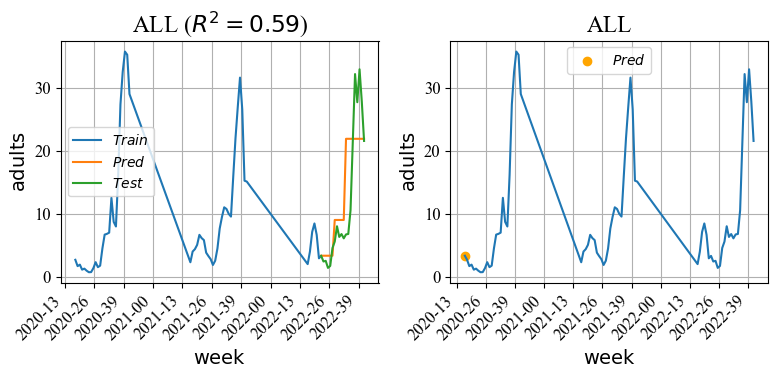

In [62]:
def melt(df, date_attr, column, target_measure):
    if column != None:
        adf = df[[x for x in df.columns if sep not in x or target_measure in x]]
        adf = pd.melt(adf, id_vars=date_attr, value_vars=[x for x in pdf.columns if target_measure in x], var_name=column, value_name=target_measure)
        adf[column] = adf[column].apply(lambda x: x.replace(f"{target_measure}{sep}", ""))
    else:
        adf = df
    return adf

def timeseries(df, date_attr, column, target_measure, model, figtitle="dt"):
    targets = [x for x in df.columns if sep in x and target_measure in x]
    actual_targets = [c for c in targets if df[c].isnull().any()]
    fig, axs = plt.subplots(len(actual_targets), 2, figsize=(8, 1 + 3*len(actual_targets)), sharex=False, sharey=False)  # Create a figure and subplots
    axs = axs.flatten()  # Flatten the axs array if it's a multi-dimensional array
    i = 0
    for c in actual_targets:
        cdf = df.drop(columns=[x for x in targets if x != c], axis=1)  # drop the wrong target measures 
        cdf = df.drop(columns=[x for x in df.columns if sep in x and c.split(sep)[1] not in x], axis=1)  # drop the wrong slices 
        cdf, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = model(cdf, c, date_attr=date_attr)
        df[c] = cdf[c]
        
        # plot
        fig.autofmt_xdate()
        axs[i].plot(cdf[date_attr].loc[X_train.index], y_train, label="$Train$")
        if y_pred is not None:
            axs[i].plot(cdf[date_attr].loc[X_test.index], y_pred, label="$Pred$")
        axs[i].plot(cdf[date_attr].loc[X_test.index], y_test, label="$Test$") # , c='darkorange'
        axs[i + 1].plot(cdf[date_attr], y)
        axs[i + 1].scatter(cdf[date_attr].loc[missing_values_df.index], missing_values_df[c], label="$Pred$", c='orange')
        for j in range(2):
            title = f'{c.split(sep)[1]}' + (f' ($R^2={max(0.0, round(value, 2))}$)' if j == 0 else '')
            myFmt = DateFormatter("%Y-%W")
            axs[i + j].tick_params(axis='x', rotation=45)
            axs[i + j].xaxis.set_major_formatter(myFmt)
            axs[i + j].set_title(title)
            axs[i + j].set_xlabel('$\\sf{' + date_attr.replace("week_in_year", "week") + '}$')
            axs[i + j].set_ylabel('$\\sf{' + c.split(sep)[0].replace('avg', '') + '}$')
            axs[i + j].grid()
            if i == 0:
                axs[i + j].legend()
        i += 2
    fig.tight_layout()
    for ext in ["svg", "pdf"]: fig.savefig(f"{figtitle}_{c}.{ext}")
    return melt(df, date_attr, column, target_measure)


adf = timeseries(pdf.copy(deep=True), date_attr, column, target_measure, dtree, figtitle="dt")
# adf


,week_in_year,avgsmall_instars!ALL,avgadults!ALL,avgcum_degree_days!ALL
0,2020-04-27,0.000000,1.488605,65.878782
1,2020-05-04,0.000000,2.692929,65.878782
2,2020-05-11,0.000000,1.687571,96.683901
3,2020-05-18,0.000000,1.927034,140.165360
4,2020-05-25,0.000000,1.129825,195.383470
...,...,...,...,...
73,2022-09-19,0.757296,32.157112,1646.070954
74,2022-09-26,0.101182,27.691720,1671.562097
75,2022-10-03,0.042105,32.913214,1705.673680
76,2022-10-10,0.021978,27.772684,1742.296697


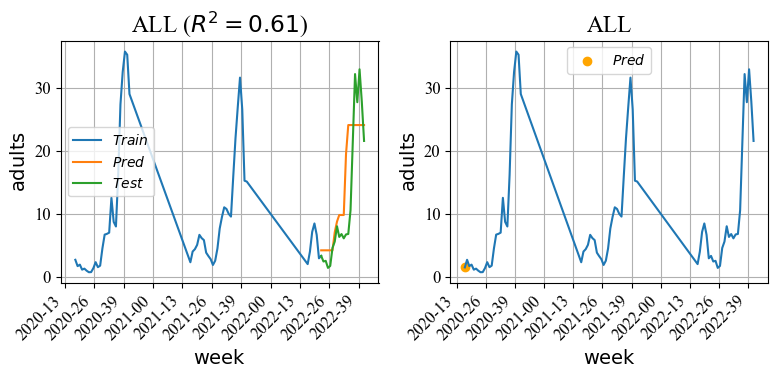

In [63]:
timeseries(pdf.copy(deep=True), date_attr, column, target_measure, forest, figtitle="rf")

{'p1': 3, 'p2': 1, 'p3': 1, 'p4': 3, 'p5': 2, 'p6': 1, 'p7': 4}
{'p1': 1, 'p2': 3, 'p3': 1, 'p4': 3, 'p5': 3, 'p6': 3, 'p7': 4}
{'p1': 3, 'p2': 2, 'p3': 1, 'p4': 1, 'p5': 1, 'p6': 1, 'p7': 4}
{'p1': 3, 'p2': 3, 'p3': 1, 'p4': 3, 'p5': 1, 'p6': 3, 'p7': 12}
{'p1': 3, 'p2': 3, 'p3': 2, 'p4': 1, 'p5': 2, 'p6': 3, 'p7': 7}
{'p1': 1, 'p2': 1, 'p3': 3, 'p4': 2, 'p5': 2, 'p6': 2, 'p7': 4}
{'p1': 1, 'p2': 2, 'p3': 1, 'p4': 1, 'p5': 2, 'p6': 1, 'p7': 7}
{'p1': 2, 'p2': 3, 'p3': 2, 'p4': 1, 'p5': 3, 'p6': 2, 'p7': 12}
{'p1': 1, 'p2': 2, 'p3': 1, 'p4': 3, 'p5': 2, 'p6': 3, 'p7': 12}
{'p1': 2, 'p2': 3, 'p3': 1, 'p4': 3, 'p5': 1, 'p6': 1, 'p7': 12}


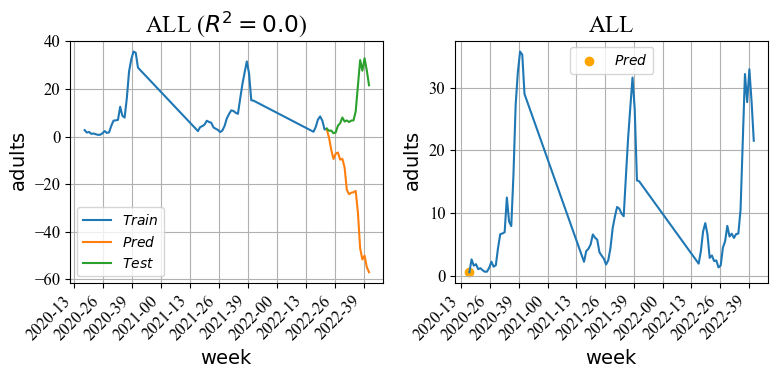

In [64]:
def sarimax(df, target_measure, date_attr, forecast_steps=test_size):
    # Create a separate dataframe for rows with missing values in the target column
    mydf = df
    missing_values_df = df[df.isnull().any(axis=1)]
    missing_indices = missing_values_df.index
    df = df.dropna()
    exog = [x for x in df.columns if target_measure.split(sep)[0] not in x and x != date_attr]
    X_train, y_train, X_test, y_test = df[exog][:-forecast_steps+1], df[target_measure][:-forecast_steps+1], df[exog][-forecast_steps:], df[target_measure][-forecast_steps:]
    y_pred = None
    param_space = {
        'p1': [1, 2, 3],
        'p2': [1, 2, 3],
        'p3': [1, 2, 3],
        'p4': [1, 2, 3],
        'p5': [1, 2, 3],
        'p6': [1, 2, 3],
        'p7': [4, 7, 12],
    }
    best_metric, best_hyperparameters = float('inf'), {}  # For minimization tasks, use 'inf' for maximization
    for _ in range(n_iter):
        try:
            # Generate a random set of hyperparameters
            chp = {param: random.choice(values) for param, values in param_space.items()}
            print(chp)
            # Train and evaluate the model with the current set of hyperparameters
            order = (chp["p1"] , chp["p2"], chp["p3"]) # to tune 
            seasonal_order = (chp["p4"], chp["p5"], chp["p6"], chp["p7"]) # to tune
            if len(exog) == 0:
                model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
            else:
                model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
            results = model.fit(disp=False)
            if len(exog) == 0:
                fcst = results.get_forecast(steps=forecast_steps)
            else:
                fcst = results.get_forecast(steps=forecast_steps, exog=X_test)
            y_pred = fcst.predicted_mean
            y_pred.index = y_test.index
            current_metric = r2_score(y_test, y_pred)
            # Update the best hyperparameters if the current configuration is better
            if current_metric < best_metric:
                best_metric = current_metric
                best_hyperparameters = chp
                best_forecast = y_pred
                best_fcts = fcst
                best_model = results
        except Exception as e:
            print(e)
    
    try:
        chp = best_hyperparameters
        order = (chp["p1"], chp["p2"], chp["p3"])
        seasonal_order = (chp["p4"], chp["p5"], chp["p6"], chp["p7"])
        model = SARIMAX(endog=df[target_measure], exog=df[exog], order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        forecast = results.get_prediction(start=missing_indices[0], end=missing_indices[-1], exog=mydf[exog].loc[missing_indices]).predicted_mean
        forecast.index = mydf.loc[missing_indices[0]:missing_indices[-1]].index
        missing_values_df[target_measure] = forecast
        missing_values_df[target_measure] = missing_values_df[target_measure].apply(lambda x: max(x, 0))
        mydf.loc[mydf[target_measure].isnull(), target_measure] = missing_values_df[target_measure]
    except Exception as e:
        print(e)
        
    return mydf, mydf[target_measure], X_train, y_train, X_test, y_test, y_pred, missing_values_df, best_metric

adf = timeseries(pdf.copy(deep=True), date_attr, column, target_measure, sarimax, figtitle="sarimax")
#adf.info()

In [67]:
def varmax(df, date_attr, target_measure, forecast_steps=test_size):
    # Create a separate dataframe for rows with missing values in the target column
    exog = [x for x in df.columns if target_measure.split(sep)[0] not in x and x != date_attr]
    endo = [x for x in df.columns if target_measure in x]
    print(f"Exogeneous: {exog}, Endogeneous: {endo}")
    all_values = df
    missing_indices = df[df.isnull().any(axis=1)].index
    df = df.dropna()
    X_train, Y_train, X_test, Y_test = df[exog][:-forecast_steps+1], df[endo][:-forecast_steps+1], df[exog][-forecast_steps:], df[endo][-forecast_steps:]
    Y_pred = None
    param_space = {
        'p1': [1],
        'p2': [1]
    }
    best_metric, best_hyperparameters = float('inf'), {}  # For minimization tasks, use 'inf' for maximization
    for _ in range(1): # n_iter
        # try:
        # Generate a random set of hyperparameters
        chp = {param: random.choice(values) for param, values in param_space.items()}
        print(chp)
        model = VARMAX(endog=Y_train, exog=X_train, order=(chp["p1"], chp["p2"]))
        results = model.fit(iterations=100, disp=False)
        fcst = results.get_forecast(steps=forecast_steps, exog=X_test)
        Y_pred = fcst.predicted_mean
        Y_pred.index = y_test.index
        current_metric = r2_score(Y_test, Y_pred)
        # Update the best hyperparameters if the current configuration is better
        if current_metric < best_metric:
            best_metric = current_metric
            best_hyperparameters = chp
            best_forecast = Y_pred
            best_fcts = fcst
            best_model = results
        # except Exception as e:
        #     print(e)
    
    # try:
    chp = best_hyperparameters
    model = VARMAX(endog=df[endo], exog=df[exog], order=(chp["p1"], chp["p2"]))
    results = model.fit(iterations=100, disp=False)
    forecast = results.get_prediction(start=missing_indices[0], end=missing_indices[-1], exog=mydf[exog].loc[missing_indices]).predicted_mean
    forecast.index = all_values.loc[missing_indices[0]:missing_indices[-1]].index
    all_values[endo] = all_values[endo].fillna(forecast)
    # except Exception as e:
    #     print(e)
    return mydf, mydf[endo], X_train, Y_train, X_test, Y_test, Y_pred, forecast, best_metric

mydf = pdf.copy(deep=True)
random_series = pd.Series(np.random.rand(len(mydf)))
n = len(mydf)
mydf[f"{target_measure}{sep}FOO"] = pd.Series(np.random.rand(len(mydf) - 5))
mydf.info()
X, Y, X_train, Y_train, X_test, Y_test, Y_pred, missing_values_df, best_metric = varmax(mydf, date_attr, target_measure)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week_in_year            78 non-null     datetime64[ns]
 1   avgsmall_instars!ALL    78 non-null     float64       
 2   avgadults!ALL           77 non-null     float64       
 3   avgcum_degree_days!ALL  78 non-null     float64       
 4   avgadults!FOO           73 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 3.2 KB
Exogeneous: ['avgsmall_instars!ALL', 'avgcum_degree_days!ALL'], Endogeneous: ['avgadults!ALL', 'avgadults!FOO']
{'p1': 1, 'p2': 1}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week_in_year            78 non-null     datetime64[ns]
 1   a

In [66]:
# def autots(df, target_measure, date_attr, forecast_steps=test_size):
#     targets = [x for x in df.columns if f"{target_measure}{sep}"  in x]
#     actual_targets = [c for c in targets if df[c].isnull().any()]
#     df.set_index(date_attr, inplace=True)

#     model = AutoTS(
#         forecast_length=test_size,
#         frequency='infer',
#         prediction_interval=0.9,
#         ensemble='auto',
#         model_list="superfast", # "fast",  # "superfast", "default", "fast_parallel"
#         transformer_list="superfast", # "fast",
#         drop_most_recent=1,
#         max_generations=4,
#         num_validations=2,
#         validation_method="backwards"
#     )
#     model = model.fit(df)
#     prediction = model.predict()
    # fig, axs = plt.subplots(len(actual_targets), 2, figsize=(8, 1 + 3*len(actual_targets)), sharex=False, sharey=False)  # Create a figure and subplots
    # axs = axs.flatten()  # Flatten the axs array if it's a multi-dimensional array
    # plot a sample
#     prediction.plot(model.df_wide_numeric, series=model.df_wide_numeric.columns[0], start_date="2017-01-01")
    # Print the details of the best model
    # print(model)
    # # point forecasts dataframe
    # forecasts_df = prediction.forecast
    # # upper and lower forecasts
    # forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast
    # # accuracy of all tried model results
    # model_results = model.results()
    # # and aggregated from cross validation
    # validation_results = model.results("validation")
#     return prediction

# prediction = autots(pdf.copy(deep=True), target_measure, date_attr)
# prediction